In [60]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumRegister, QuantumCircuit
from qiskit.circuit.library import IntegerComparator
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem, MaximumLikelihoodAmplitudeEstimation,FasterAmplitudeEstimation
from qiskit_aer.primitives import Sampler

In [22]:
# set problem parameters
q = 2
z_max = 2
z_values = np.linspace(-z_max, z_max, 2**q)
prob_default_k = [0.15, 0.25,0.56,0.3]#considering 4 assets
sens_default_z = [0.1, 0.05,0.03, 0.4]
loss_given_default_k = [1, 2,3,4]
num_assets = len(prob_default_k)
alpha = 0.05

In [23]:
#pip install 'qiskit[finance]'

In [24]:
from qiskit_finance.circuit.library import GaussianConditionalIndependenceModel as GCI

uncertainty_model = GCI(q, z_max, prob_default_k, sens_default_z)


In [25]:
uncertainty_model.draw()

┌───────┐
q_0: ┤0      ├
     │       │
q_1: ┤1      ├
     │       │
q_2: ┤2      ├
     │  P(X) │
q_3: ┤3      ├
     │       │
q_4: ┤4      ├
     │       │
q_5: ┤5      ├
     └───────┘

In [26]:
uncertainty_measure = uncertainty_model.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(uncertainty_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()
print(binary_probabilities)
print(job.result())

{'101010': 0.001953125, '110110': 0.0009765625, '000100': 0.0009765625, '001101': 0.0029296875, '111100': 0.00390625, '111010': 0.005859375, '001000': 0.001953125, '110100': 0.0107421875, '011110': 0.0029296875, '010000': 0.0009765625, '100110': 0.005859375, '100100': 0.0029296875, '010001': 0.07421875, '010110': 0.0087890625, '000001': 0.0615234375, '100101': 0.0146484375, '100000': 0.0048828125, '111101': 0.0087890625, '011100': 0.001953125, '001001': 0.017578125, '001011': 0.005859375, '011011': 0.0029296875, '101101': 0.0048828125, '101000': 0.005859375, '001010': 0.03515625, '011001': 0.0390625, '111001': 0.0224609375, '100001': 0.0380859375, '000101': 0.013671875, '011101': 0.0126953125, '110001': 0.0625, '011000': 0.0029296875, '010100': 0.0029296875, '000010': 0.1455078125, '111000': 0.009765625, '110000': 0.015625, '011010': 0.0390625, '110010': 0.0126953125, '110101': 0.021484375, '101100': 0.00390625, '101001': 0.017578125, '000011': 0.04296875, '000110': 0.009765625, '10001

In [27]:
print(len(binary_probabilities))
print(binary_probabilities.items())

48
dict_items([('101010', 0.001953125), ('110110', 0.0009765625), ('000100', 0.0009765625), ('001101', 0.0029296875), ('111100', 0.00390625), ('111010', 0.005859375), ('001000', 0.001953125), ('110100', 0.0107421875), ('011110', 0.0029296875), ('010000', 0.0009765625), ('100110', 0.005859375), ('100100', 0.0029296875), ('010001', 0.07421875), ('010110', 0.0087890625), ('000001', 0.0615234375), ('100101', 0.0146484375), ('100000', 0.0048828125), ('111101', 0.0087890625), ('011100', 0.001953125), ('001001', 0.017578125), ('001011', 0.005859375), ('011011', 0.0029296875), ('101101', 0.0048828125), ('101000', 0.005859375), ('001010', 0.03515625), ('011001', 0.0390625), ('111001', 0.0224609375), ('100001', 0.0380859375), ('000101', 0.013671875), ('011101', 0.0126953125), ('110001', 0.0625), ('011000', 0.0029296875), ('010100', 0.0029296875), ('000010', 0.1455078125), ('111000', 0.009765625), ('110000', 0.015625), ('011010', 0.0390625), ('110010', 0.0126953125), ('110101', 0.021484375), ('10

In [28]:
np.zeros(2**q)

array([0., 0., 0., 0.])

In [29]:
# analyze uncertainty circuit and determine exact solutions
p_z = np.zeros(2**q)
p_default = np.zeros(num_assets)
values = []
probabilities = []
num_qubits = uncertainty_model.num_qubits

for i, prob in binary_probabilities.items():
    # extract value of Z and corresponding probability
    i_normal = int(i[-q:], 2)
    p_z[i_normal] += prob

    # determine overall default probability for k
    loss = 0
    for k in range(num_assets):
        if i[num_assets - k - 1] == "1":
            p_default[k] += prob
            loss += loss_given_default_k[k]

    values += [loss]
    probabilities += [prob]


values = np.array(values)
probabilities = np.array(probabilities)

print("values", values)
print("probabilities", probabilities)
expected_loss = np.dot(values, probabilities)
losses = np.sort(np.unique(values))

print("expected_loss", expected_loss)
print("losses", losses)

pdf = np.zeros(len(losses))
for i, v in enumerate(losses):
    pdf[i] += sum(probabilities[values == v])
cdf = np.cumsum(pdf)

i_var = np.argmax(cdf >= 1 - alpha)#returns indices of the max element of the array in a particular axis.
exact_var = losses[i_var]#max loss
exact_cvar = np.dot(pdf[(i_var + 1) :], losses[(i_var + 1) :]) / sum(pdf[(i_var + 1) :])

values [ 6  8  1  3 10  9  2  8  6  3  5  5  3  4  0  5  4 10  6  2  2  5  7  6
  2  5  9  4  1  6  7  5  4  0  9  7  5  7  8  7  6  0  1  4  4  3  3  3]
probabilities [0.00195312 0.00097656 0.00097656 0.00292969 0.00390625 0.00585938
 0.00195312 0.01074219 0.00292969 0.00097656 0.00585938 0.00292969
 0.07421875 0.00878906 0.06152344 0.01464844 0.00488281 0.00878906
 0.00195312 0.01757812 0.00585938 0.00292969 0.00488281 0.00585938
 0.03515625 0.0390625  0.02246094 0.03808594 0.01367188 0.01269531
 0.0625     0.00292969 0.00292969 0.14550781 0.00976562 0.015625
 0.0390625  0.01269531 0.02148438 0.00390625 0.01757812 0.04296875
 0.00976562 0.01660156 0.015625   0.00195312 0.03027344 0.13378906]
expected_loss 3.453125
losses [ 0  1  2  3  4  5  6  7  8  9 10]


In [30]:
print(len(values))

48


In [31]:
print("Expected Loss E[L]:                %.4f" % expected_loss)
print("Value at Risk VaR[L]:              %.4f" % exact_var)
print("P[L <= VaR[L]]:                    %.4f" % cdf[exact_var])
print("Conditional Value at Risk CVaR[L]: %.4f" % exact_cvar)

Expected Loss E[L]:                3.4531
Value at Risk VaR[L]:              9.0000
P[L <= VaR[L]]:                    0.9873
Conditional Value at Risk CVaR[L]: 10.0000


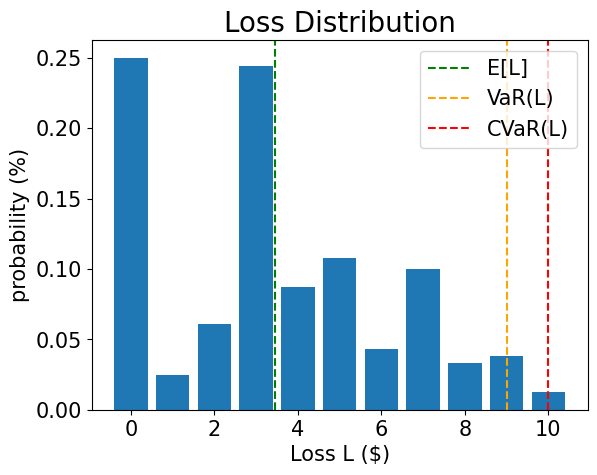

In [32]:
# plot loss PDF, expected loss, var, and cvar
plt.bar(losses, pdf)
plt.axvline(expected_loss, color="green", linestyle="--", label="E[L]")
plt.axvline(exact_var, color="orange", linestyle="--", label="VaR(L)")
plt.axvline(exact_cvar, color="red", linestyle="--", label="CVaR(L)")
plt.legend(fontsize=15)
plt.xlabel("Loss L ($)", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Loss Distribution", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

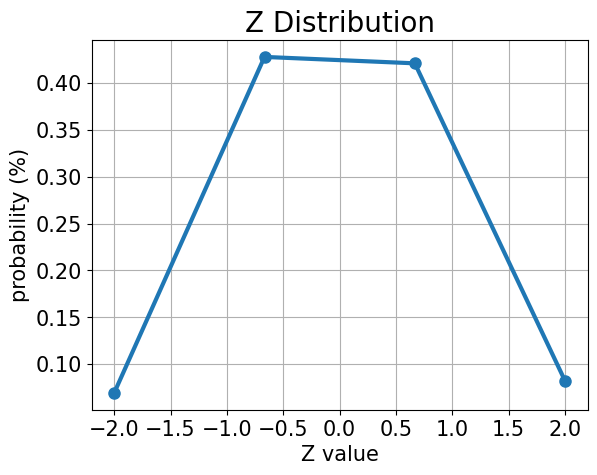

In [33]:
# plot results for Z
plt.plot(z_values, p_z, "o-", linewidth=3, markersize=8)
plt.grid()
plt.xlabel("Z value", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Z Distribution", size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

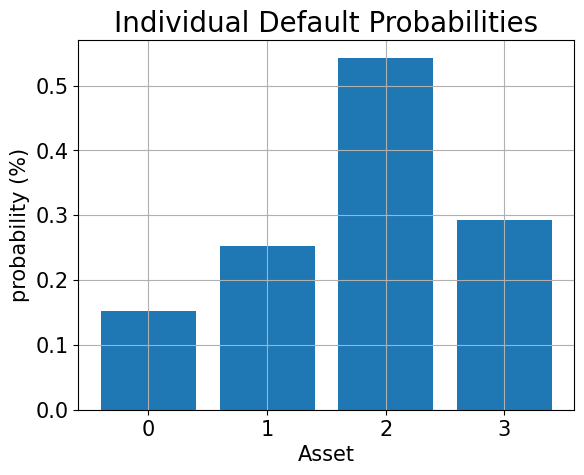

In [34]:
# plot results for default probabilities
plt.bar(range(num_assets), p_default)
plt.xlabel("Asset", size=15)
plt.ylabel("probability (%)", size=15)
plt.title("Individual Default Probabilities", size=20)
plt.xticks(range(num_assets), size=15)
plt.yticks(size=15)
plt.grid()
plt.show()

In [35]:
 [0] * q + loss_given_default_k

[0, 0, 1, 2, 3, 4]

In [45]:
# add Z qubits with weight/loss 0
from qiskit.circuit.library import WeightedAdder
#weighted sum of qubit registers.
agg = WeightedAdder(q + num_assets, [0] * q + loss_given_default_k)
print(agg)
print(agg.num_control_qubits)

         ┌───────────────┐
state_0: ┤0              ├
         │               │
state_1: ┤1              ├
         │               │
state_2: ┤2              ├
         │               │
state_3: ┤3              ├
         │               │
state_4: ┤4              ├
         │               │
state_5: ┤5              ├
         │               │
  sum_0: ┤6              ├
         │   circuit-306 │
  sum_1: ┤7              ├
         │               │
  sum_2: ┤8              ├
         │               │
  sum_3: ┤9              ├
         │               │
carry_0: ┤10             ├
         │               │
carry_1: ┤11             ├
         │               │
carry_2: ┤12             ├
         │               │
control: ┤13             ├
         └───────────────┘
1


In [41]:
from qiskit.circuit.library import LinearAmplitudeFunction

# define linear objective function
breakpoints = [0]
slopes = [1]
offsets = [0]
f_min = 0
f_max = sum(loss_given_default_k)
c_approx = 0.25

objective = LinearAmplitudeFunction(
    agg.num_sum_qubits,
    slope=slopes,
    offset=offsets,
    # max value that can be reached by the qubit register (will not always be reached)
    domain=(0, 2**agg.num_sum_qubits - 1),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints,
)

In [84]:
print(objective)
print(objective.data)

       ┌────┐
q46_0: ┤0   ├
       │    │
q46_1: ┤1   ├
       │    │
q46_2: ┤2 F ├
       │    │
q46_3: ┤3   ├
       │    │
  q47: ┤4   ├
       └────┘
[CircuitInstruction(operation=Instruction(name='F', num_qubits=5, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(4, 'q46'), 0), Qubit(QuantumRegister(4, 'q46'), 1), Qubit(QuantumRegister(4, 'q46'), 2), Qubit(QuantumRegister(4, 'q46'), 3), Qubit(QuantumRegister(1, 'q47'), 0)), clbits=())]


In [43]:

# define the registers for convenience and readability
qr_state = QuantumRegister(uncertainty_model.num_qubits, "state")
qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits, "carry")
qr_obj = QuantumRegister(1, "objective")
print(qr_state[:] + qr_sum[:] + qr_carry[:])

[Qubit(QuantumRegister(6, 'state'), 0), Qubit(QuantumRegister(6, 'state'), 1), Qubit(QuantumRegister(6, 'state'), 2), Qubit(QuantumRegister(6, 'state'), 3), Qubit(QuantumRegister(6, 'state'), 4), Qubit(QuantumRegister(6, 'state'), 5), Qubit(QuantumRegister(4, 'sum'), 0), Qubit(QuantumRegister(4, 'sum'), 1), Qubit(QuantumRegister(4, 'sum'), 2), Qubit(QuantumRegister(4, 'sum'), 3), Qubit(QuantumRegister(3, 'carry'), 0), Qubit(QuantumRegister(3, 'carry'), 1), Qubit(QuantumRegister(3, 'carry'), 2)]


In [50]:

qr_state = QuantumRegister(uncertainty_model.num_qubits, "state")
qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits, "carry")
qr_ctrl = QuantumRegister(agg.num_control_qubits,"control")
qr_obj = QuantumRegister(1, "objective")

# define the circuit
state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry,qr_ctrl, name="A")

# draw the circuit
state_preparation.draw()

state_0: 
           
  state_1: 
           
  state_2: 
           
  state_3: 
           
  state_4: 
           
  state_5: 
           
objective: 
           
    sum_0: 
           
    sum_1: 
           
    sum_2: 
           
    sum_3: 
           
  carry_0: 
           
  carry_1: 
           
  carry_2: 
           
  control:

In [51]:
# load the random variable
state_preparation.append(uncertainty_model.to_gate(), qr_state)

state_preparation.draw()

┌───────┐
  state_0: ┤0      ├
           │       │
  state_1: ┤1      ├
           │       │
  state_2: ┤2      ├
           │  P(X) │
  state_3: ┤3      ├
           │       │
  state_4: ┤4      ├
           │       │
  state_5: ┤5      ├
           └───────┘
objective: ─────────
                    
    sum_0: ─────────
                    
    sum_1: ─────────
                    
    sum_2: ─────────
                    
    sum_3: ─────────
                    
  carry_0: ─────────
                    
  carry_1: ─────────
                    
  carry_2: ─────────
                    
  control: ─────────

In [52]:
# aggregate
state_preparation.append(agg.to_gate(), qr_state[:] + qr_sum[:] + qr_carry[:]+qr_ctrl[:])
state_preparation.draw()


┌───────┐┌─────────┐
  state_0: ┤0      ├┤0        ├
           │       ││         │
  state_1: ┤1      ├┤1        ├
           │       ││         │
  state_2: ┤2      ├┤2        ├
           │  P(X) ││         │
  state_3: ┤3      ├┤3        ├
           │       ││         │
  state_4: ┤4      ├┤4        ├
           │       ││         │
  state_5: ┤5      ├┤5        ├
           └───────┘│         │
objective: ─────────┤         ├
                    │         │
    sum_0: ─────────┤6  adder ├
                    │         │
    sum_1: ─────────┤7        ├
                    │         │
    sum_2: ─────────┤8        ├
                    │         │
    sum_3: ─────────┤9        ├
                    │         │
  carry_0: ─────────┤10       ├
                    │         │
  carry_1: ─────────┤11       ├
                    │         │
  carry_2: ─────────┤12       ├
                    │         │
  control: ─────────┤13       ├
                    └─────────┘

In [53]:
# linear objective function
state_preparation.append(objective.to_gate(), qr_sum[:] + qr_obj[:])

state_preparation.draw()

┌───────┐┌─────────┐      
  state_0: ┤0      ├┤0        ├──────
           │       ││         │      
  state_1: ┤1      ├┤1        ├──────
           │       ││         │      
  state_2: ┤2      ├┤2        ├──────
           │  P(X) ││         │      
  state_3: ┤3      ├┤3        ├──────
           │       ││         │      
  state_4: ┤4      ├┤4        ├──────
           │       ││         │      
  state_5: ┤5      ├┤5        ├──────
           └───────┘│         │┌────┐
objective: ─────────┤         ├┤4   ├
                    │         ││    │
    sum_0: ─────────┤6  adder ├┤0   ├
                    │         ││    │
    sum_1: ─────────┤7        ├┤1 F ├
                    │         ││    │
    sum_2: ─────────┤8        ├┤2   ├
                    │         ││    │
    sum_3: ─────────┤9        ├┤3   ├
                    │         │└────┘
  carry_0: ─────────┤10       ├──────
                    │         │      
  carry_1: ─────────┤11       ├──────
                    │         │      
  carry_2: ─────────┤12       ├──────
                    │         │      
  control: ─────────┤13       ├──────
                    └─────────┘

In [54]:
# uncompute aggregation

state_preparation.append(agg.to_gate().inverse(), qr_state[:] + qr_sum[:] + qr_carry[:]+qr_ctrl[:])
state_preparation.draw()

┌───────┐┌─────────┐      ┌────────────┐
  state_0: ┤0      ├┤0        ├──────┤0           ├
           │       ││         │      │            │
  state_1: ┤1      ├┤1        ├──────┤1           ├
           │       ││         │      │            │
  state_2: ┤2      ├┤2        ├──────┤2           ├
           │  P(X) ││         │      │            │
  state_3: ┤3      ├┤3        ├──────┤3           ├
           │       ││         │      │            │
  state_4: ┤4      ├┤4        ├──────┤4           ├
           │       ││         │      │            │
  state_5: ┤5      ├┤5        ├──────┤5           ├
           └───────┘│         │┌────┐│            │
objective: ─────────┤         ├┤4   ├┤            ├
                    │         ││    ││            │
    sum_0: ─────────┤6  adder ├┤0   ├┤6  adder_dg ├
                    │         ││    ││            │
    sum_1: ─────────┤7        ├┤1 F ├┤7           ├
                    │         ││    ││            │
    sum_2: ─────────┤8        ├┤2   ├┤8           ├
                    │         ││    ││            │
    sum_3: ─────────┤9        ├┤3   ├┤9           ├
                    │         │└────┘│            │
  carry_0: ─────────┤10       ├──────┤10          ├
                    │         │      │            │
  carry_1: ─────────┤11       ├──────┤11          ├
                    │         │      │            │
  carry_2: ─────────┤12       ├──────┤12          ├
                    │         │      │            │
  control: ─────────┤13       ├──────┤13          ├
                    └─────────┘      └────────────┘

For num of assets = 5 , I get below error:
---------------------------------------------------------------------------

CircuitError                              Traceback (most recent call last)
Cell In[62], line 13
     10 state_preparation.append(uncertainty_model.to_gate(), qr_state)
     12 # aggregate
---> 13 state_preparation.append(agg.to_gate(),[qr_state[:] + qr_sum[:] + qr_carry[:]])
     15 # linear objective function
     16 state_preparation.append(objective.to_gate(), qr_sum[:] + qr_obj[:])

<h3>File ~/opt/anaconda3/envs/QCQML/lib/python3.9/site-packages/qiskit/circuit/quantumcircuit.py:1264, in QuantumCircuit.append(self, instruction, qargs, cargs)
   1262 instructions = InstructionSet(resource_requester=requester)
   1263 if isinstance(operation, Instruction):
-> 1264     for qarg, carg in operation.broadcast_arguments(expanded_qargs, expanded_cargs):
   1265         self._check_dups(qarg)
   1266         instruction = CircuitInstruction(operation, qarg, carg)

File ~/opt/anaconda3/envs/QCQML/lib/python3.9/site-packages/qiskit/circuit/gate.py:202, in Gate.broadcast_arguments(self, qargs, cargs)
    165 """Validation and handling of the arguments and its relationship.
    166 
    167 For example, ``cx([q[0],q[1]], q[2])`` means ``cx(q[0], q[2]); cx(q[1], q[2])``. This
   (...)
    199         arguments does not match the gate expectation.
    200 """
    201 if len(qargs) != self.num_qubits or cargs:
--> 202     raise CircuitError(
    203         f"The amount of qubit({len(qargs)})/clbit({len(cargs)}) arguments does"
    204         f" not match the gate expectation ({self.num_qubits})."
    205     )
    207 if any(not qarg for qarg in qargs):
    208     raise CircuitError("One or more of the arguments are empty")

<h3>CircuitError: 'The amount of qubit(1)/clbit(0) arguments does not match the gate expectation (15).'
    
<h2> The above error occurs when num of assets =3 and no of qbits to represent Z =3 , in absence of control_bits

In [56]:
"""
validate the quantum circuit representing the objective function by just simulating it directly and analyzing the probability of the objective qubit being in the 
 state, i.e., the value QAE will eventually approximate.
"""
state_preparation_measure = state_preparation.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(state_preparation_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()
print(binary_probabilities)

{'000000001001101': 0.0009765625, '000000001011100': 0.0009765625, '000000000101101': 0.0029296875, '000000000011110': 0.0009765625, '000000001111110': 0.0009765625, '000000000111000': 0.0029296875, '000000000010000': 0.0029296875, '000000001111010': 0.0029296875, '000000001100101': 0.005859375, '000000000101000': 0.0009765625, '000000000110101': 0.0048828125, '000000001110101': 0.005859375, '000000000001110': 0.001953125, '000000000111101': 0.001953125, '000000001011101': 0.0009765625, '000000001000101': 0.00390625, '000000001010101': 0.0078125, '000000001001001': 0.0078125, '000000000010011': 0.0185546875, '000000001110011': 0.0009765625, '000000000000111': 0.001953125, '000000001010000': 0.001953125, '000000000001000': 0.0009765625, '000000000111010': 0.0009765625, '000000000111100': 0.001953125, '000000000010101': 0.009765625, '000000000011101': 0.0009765625, '000000000000000': 0.0009765625, '000000001011011': 0.0029296875, '000000000110001': 0.0341796875, '000000000000101': 0.0117

In [57]:
# evaluate the result
value = 0
for i, prob in binary_probabilities.items():
    if prob > 1e-6 and i[-(len(qr_state) + 1) :][0] == "1":
        value += prob

print("Exact Expected Loss:   %.4f" % expected_loss)
print("Exact Operator Value:  %.4f" % value)
print("Mapped Operator value: %.4f" % objective.post_processing(value))

Exact Expected Loss:   3.4531
Exact Operator Value:  0.4375
Mapped Operator value: 3.4085


In [62]:
# set target precision and confidence level
epsilon_target = 0.03
alpha = 0.05

problem = EstimationProblem(
    state_preparation=state_preparation,
    objective_qubits=[len(qr_state)],
    post_processing=objective.post_processing,
)
# construct amplitude estimation
ae = IterativeAmplitudeEstimation(
    epsilon_target=epsilon_target, alpha=alpha, sampler=Sampler(run_options={"shots": 100})
)
result = ae.estimate(problem)

# print results
conf_int = np.array(result.confidence_interval_processed)
print("Exact value:    \t%.4f" % expected_loss)
print("Estimated value:\t%.4f" % result.estimation_processed)
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Exact value:    	3.4531
Estimated value:	3.3954
Confidence interval: 	[2.7211, 4.0697]


In [66]:
"""This class implements the quantum amplitude estimation (QAE) algorithm without phase estimation.
In comparison to the original QAE algorithm , this implementation relies solely on different 
powers of the Grover operator and does not require additional evaluation qubits."""

problem = EstimationProblem(
    state_preparation=state_preparation,
    objective_qubits=[len(qr_state)],
    post_processing=objective.post_processing,
)
# construct MaximumLikelihoodAmplitudeEstimation
max_lhood_ae = MaximumLikelihoodAmplitudeEstimation(
    evaluation_schedule=3,  # log2 of the maximal Grover power
    sampler=sampler
)
max_lhood_result = max_lhood_ae.estimate(problem)

# print results
conf_int = np.array(max_lhood_result.confidence_interval_processed)
print("Exact value:    \t%.4f" % expected_loss)
print("Estimated value:\t%.4f" % max_lhood_result.estimation_processed)

Exact value:    	3.4531
Estimated value:	3.5088


In [67]:
"""
The Faster Amplitude Estimation (FAE)  algorithm is a variant of Quantum Amplitude Estimation (QAE), 
where the Quantum Phase Estimation (QPE) by an iterative Grover search
"""

# construct FastAmplitudeEstimation
fast_ae = FasterAmplitudeEstimation(
    delta=0.01,  # target accuracy
    maxiter=3,  # determines the maximal power of the Grover operator
    sampler=sampler,
)

fast_ae_result = fast_ae.estimate(problem)
# print results
conf_int = np.array(fast_ae_result.confidence_interval_processed)
print("Exact value:    \t%.4f" % expected_loss)
print("Estimated value:\t%.4f" % fast_ae_result.estimation_processed)

Exact value:    	3.4531
Estimated value:	3.7647


In [72]:
# set x value to estimate the CDF
x_eval = 2

comparator = IntegerComparator(agg.num_sum_qubits, x_eval + 1, geq=False)
comparator.draw()

┌──────┐
state_0: ┤0     ├
         │      │
state_1: ┤1     ├
         │      │
state_2: ┤2     ├
         │      │
state_3: ┤3     ├
         │  cmp │
compare: ┤4     ├
         │      │
   a3_0: ┤5     ├
         │      │
   a3_1: ┤6     ├
         │      │
   a3_2: ┤7     ├
         └──────┘

In [77]:
def get_cdf_circuit(x_eval):
    # define the registers for convenience and readability
    qr_state = QuantumRegister(uncertainty_model.num_qubits, "state")
    qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
    qr_carry = QuantumRegister(agg.num_carry_qubits, "carry")
    qr_ctrl = QuantumRegister(agg.num_control_qubits, "control")
    qr_obj = QuantumRegister(1, "objective")
    qr_compare = QuantumRegister(1, "compare")

    # define the circuit
    state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry,qr_ctrl, name="A")

    # load the random variable
    state_preparation.append(uncertainty_model, qr_state)

    # aggregate
    state_preparation.append(agg, qr_state[:] + qr_sum[:] + qr_carry[:] + qr_ctrl[:])

    # comparator objective function
    comparator = IntegerComparator(agg.num_sum_qubits, x_eval + 1, geq=False)
    state_preparation.append(comparator, qr_sum[:] + qr_obj[:] + qr_carry[:])

    # uncompute aggregation
    state_preparation.append(agg.inverse(), qr_state[:] + qr_sum[:] + qr_carry[:]+qr_ctrl[:])

    return state_preparation


state_preparation = get_cdf_circuit(x_eval)

In [78]:
state_preparation.draw()

┌───────┐┌─────────┐        ┌────────────┐
  state_0: ┤0      ├┤0        ├────────┤0           ├
           │       ││         │        │            │
  state_1: ┤1      ├┤1        ├────────┤1           ├
           │       ││         │        │            │
  state_2: ┤2      ├┤2        ├────────┤2           ├
           │  P(X) ││         │        │            │
  state_3: ┤3      ├┤3        ├────────┤3           ├
           │       ││         │        │            │
  state_4: ┤4      ├┤4        ├────────┤4           ├
           │       ││         │        │            │
  state_5: ┤5      ├┤5        ├────────┤5           ├
           └───────┘│         │┌──────┐│            │
objective: ─────────┤         ├┤4     ├┤            ├
                    │         ││      ││            │
    sum_0: ─────────┤6  adder ├┤0     ├┤6  adder_dg ├
                    │         ││      ││            │
    sum_1: ─────────┤7        ├┤1     ├┤7           ├
                    │         ││      ││            │
    sum_2: ─────────┤8        ├┤2     ├┤8           ├
                    │         ││  cmp ││            │
    sum_3: ─────────┤9        ├┤3     ├┤9           ├
                    │         ││      ││            │
  carry_0: ─────────┤10       ├┤5     ├┤10          ├
                    │         ││      ││            │
  carry_1: ─────────┤11       ├┤6     ├┤11          ├
                    │         ││      ││            │
  carry_2: ─────────┤12       ├┤7     ├┤12          ├
                    │         │└──────┘│            │
  control: ─────────┤13       ├────────┤13          ├
                    └─────────┘        └────────────┘

In [79]:
state_preparation_measure = state_preparation.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(state_preparation_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()

In [80]:
# evaluate the result
var_prob = 0
for i, prob in binary_probabilities.items():
    if prob > 1e-6 and i[-(len(qr_state) + 1) :][0] == "1":
        var_prob += prob

print("Operator CDF(%s)" % x_eval + " = %.4f" % var_prob)
print("Exact    CDF(%s)" % x_eval + " = %.4f" % cdf[x_eval])

Operator CDF(2) = 0.3311
Exact    CDF(2) = 0.3350


In [81]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(state_preparation=state_preparation, objective_qubits=[len(qr_state)])
# construct amplitude estimation
ae_cdf = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100})
)
result_cdf = ae_cdf.estimate(problem)

# print results
conf_int = np.array(result_cdf.confidence_interval)
print("Exact value:    \t%.4f" % cdf[x_eval])
print("Estimated value:\t%.4f" % result_cdf.estimation)
print("Confidence interval: \t[%.4f, %.4f]" % tuple(conf_int))

Exact value:    	0.3350
Estimated value:	0.3181
Confidence interval: 	[0.3151, 0.3211]


In [87]:
def run_iter_ae_for_cdf(x_eval, epsilon=0.01, alpha=0.05, simulator="aer_simulator"):

    # construct amplitude estimation
    state_preparation = get_cdf_circuit(x_eval)
    problem = EstimationProblem(
        state_preparation=state_preparation, objective_qubits=[len(qr_state)]
    )
    iter_ae_var = IterativeAmplitudeEstimation(
        epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100})
    )
    result_var = iter_ae_var.estimate(problem)

    return result_var.estimation

In [88]:
def bisection_search(
    objective, target_value, low_level, high_level, low_value=None, high_value=None
):
    """
    Determines the smallest level such that the objective value is still larger than the target
    :param objective: objective function
    :param target: target value
    :param low_level: lowest level to be considered
    :param high_level: highest level to be considered
    :param low_value: value of lowest level (will be evaluated if set to None)
    :param high_value: value of highest level (will be evaluated if set to None)
    :return: dictionary with level, value, num_eval
    """

    # check whether low and high values are given and evaluated them otherwise
    print("--------------------------------------------------------------------")
    print("start bisection search for target value %.3f" % target_value)
    print("--------------------------------------------------------------------")
    num_eval = 0
    if low_value is None:
        low_value = objective(low_level)
        num_eval += 1
    if high_value is None:
        high_value = objective(high_level)
        num_eval += 1

    # check if low_value already satisfies the condition
    if low_value > target_value:
        return {
            "level": low_level,
            "value": low_value,
            "num_eval": num_eval,
            "comment": "returned low value",
        }
    elif low_value == target_value:
        return {"level": low_level, "value": low_value, "num_eval": num_eval, "comment": "success"}

    # check if high_value is above target
    if high_value < target_value:
        return {
            "level": high_level,
            "value": high_value,
            "num_eval": num_eval,
            "comment": "returned low value",
        }
    elif high_value == target_value:
        return {
            "level": high_level,
            "value": high_value,
            "num_eval": num_eval,
            "comment": "success",
        }

    # perform bisection search until
    print("low_level    low_value    level    value    high_level    high_value")
    print("--------------------------------------------------------------------")
    while high_level - low_level > 1:

        level = int(np.round((high_level + low_level) / 2.0))
        num_eval += 1
        value = objective(level)

        print(
            "%2d           %.3f        %2d       %.3f    %2d            %.3f"
            % (low_level, low_value, level, value, high_level, high_value)
        )

        if value >= target_value:
            high_level = level
            high_value = value
        else:
            low_level = level
            low_value = value

    # return high value after bisection search
    print("--------------------------------------------------------------------")
    print("finished bisection search")
    print("--------------------------------------------------------------------")
    return {"level": high_level, "value": high_value, "num_eval": num_eval, "comment": "success"}

In [89]:
# run bisection search to determine VaR
objective = lambda x: run_iter_ae_for_cdf(x)
bisection_result = bisection_search(
    objective, 1 - alpha, min(losses) - 1, max(losses), low_value=0, high_value=1
)
var = bisection_result["level"]

--------------------------------------------------------------------
start bisection search for target value 0.950
--------------------------------------------------------------------
low_level    low_value    level    value    high_level    high_value
--------------------------------------------------------------------
-1           0.000         4       0.685    10            1.000
 4           0.685         7       0.922    10            1.000
 7           0.922         8       0.946    10            1.000
 8           0.946         9       0.988    10            1.000
--------------------------------------------------------------------
finished bisection search
--------------------------------------------------------------------


In [91]:
print("Estimated Value at Risk: %2d" % var)
print("Exact Value at Risk:     %2d" % exact_var)
print("Estimated Probability:    %.3f" % bisection_result["value"])
print("Exact Probability:        %.3f" % cdf[exact_var])

Estimated Value at Risk:  9
Exact Value at Risk:      9
Estimated Probability:    0.988
Exact Probability:        0.987


In [92]:
# define linear objective
breakpoints = [0, var]
slopes = [0, 1]
offsets = [0, 0]  # subtract VaR and add it later to the estimate
f_min = 0
f_max = 3 - var
c_approx = 0.25

cvar_objective = LinearAmplitudeFunction(
    agg.num_sum_qubits,
    slopes,
    offsets,
    domain=(0, 2**agg.num_sum_qubits - 1),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints,
)

cvar_objective.draw()

┌────┐
q566_0: ┤0   ├
        │    │
q566_1: ┤1   ├
        │    │
q566_2: ┤2   ├
        │    │
q566_3: ┤3   ├
        │    │
  q567: ┤4 F ├
        │    │
 a11_0: ┤5   ├
        │    │
 a11_1: ┤6   ├
        │    │
 a11_2: ┤7   ├
        │    │
 a11_3: ┤8   ├
        └────┘

In [96]:
# define the registers for convenience and readability
qr_state = QuantumRegister(uncertainty_model.num_qubits, "state")
qr_sum = QuantumRegister(agg.num_sum_qubits, "sum")
qr_carry = QuantumRegister(agg.num_carry_qubits, "carry")
qr_ctrl = QuantumRegister(agg.num_control_qubits, "control")
qr_obj = QuantumRegister(1, "objective")
qr_work = QuantumRegister(cvar_objective.num_ancillas - len(qr_carry), "work")

# define the circuit
state_preparation = QuantumCircuit(qr_state, qr_obj, qr_sum, qr_carry,qr_ctrl, qr_work, name="A")

# load the random variable
state_preparation.append(uncertainty_model, qr_state)

# aggregate
state_preparation.append(agg, qr_state[:] + qr_sum[:] + qr_carry[:] + qr_ctrl[:])

# linear objective function
state_preparation.append(cvar_objective, qr_sum[:] + qr_obj[:] + qr_carry[:] + qr_work[:])

# uncompute aggregation
state_preparation.append(agg.inverse(), qr_state[:] + qr_sum[:] + qr_carry[:] +qr_ctrl[:])
state_preparation.draw()

┌───────┐┌─────────┐      ┌────────────┐
  state_0: ┤0      ├┤0        ├──────┤0           ├
           │       ││         │      │            │
  state_1: ┤1      ├┤1        ├──────┤1           ├
           │       ││         │      │            │
  state_2: ┤2      ├┤2        ├──────┤2           ├
           │  P(X) ││         │      │            │
  state_3: ┤3      ├┤3        ├──────┤3           ├
           │       ││         │      │            │
  state_4: ┤4      ├┤4        ├──────┤4           ├
           │       ││         │      │            │
  state_5: ┤5      ├┤5        ├──────┤5           ├
           └───────┘│         │┌────┐│            │
objective: ─────────┤         ├┤4   ├┤            ├
                    │         ││    ││            │
    sum_0: ─────────┤6  adder ├┤0   ├┤6  adder_dg ├
                    │         ││    ││            │
    sum_1: ─────────┤7        ├┤1   ├┤7           ├
                    │         ││    ││            │
    sum_2: ─────────┤8        ├┤2   ├┤8           ├
                    │         ││    ││            │
    sum_3: ─────────┤9        ├┤3   ├┤9           ├
                    │         ││  F ││            │
  carry_0: ─────────┤10       ├┤5   ├┤10          ├
                    │         ││    ││            │
  carry_1: ─────────┤11       ├┤6   ├┤11          ├
                    │         ││    ││            │
  carry_2: ─────────┤12       ├┤7   ├┤12          ├
                    │         ││    ││            │
  control: ─────────┤13       ├┤    ├┤13          ├
                    └─────────┘│    │└────────────┘
     work: ────────────────────┤8   ├──────────────
                               └────┘

In [97]:
state_preparation_measure = state_preparation.measure_all(inplace=False)
sampler = Sampler()
job = sampler.run(state_preparation_measure)
binary_probabilities = job.result().quasi_dists[0].binary_probabilities()


In [98]:
# evaluate the result
value = 0
for i, prob in binary_probabilities.items():
    if prob > 1e-6 and i[-(len(qr_state) + 1)] == "1":
        value += prob

# normalize and add VaR to estimate
value = cvar_objective.post_processing(value)
d = 1.0 - bisection_result["value"]
v = value / d if d != 0 else 0
normalized_value = v + var
print("Estimated CVaR: %.4f" % normalized_value)
print("Exact CVaR:     %.4f" % exact_cvar)

Estimated CVaR: 31.6728
Exact CVaR:     10.0000


In [99]:
# set target precision and confidence level
epsilon = 0.01
alpha = 0.05

problem = EstimationProblem(
    state_preparation=state_preparation,
    objective_qubits=[len(qr_state)],
    post_processing=cvar_objective.post_processing,
)
# construct amplitude estimation
ae_cvar = IterativeAmplitudeEstimation(
    epsilon_target=epsilon, alpha=alpha, sampler=Sampler(run_options={"shots": 100})
)
result_cvar = ae_cvar.estimate(problem)

In [100]:
# print results
d = 1.0 - bisection_result["value"]
v = result_cvar.estimation_processed / d if d != 0 else 0
print("Exact CVaR:    \t%.4f" % exact_cvar)
print("Estimated CVaR:\t%.4f" % (v + var))

Exact CVaR:    	10.0000
Estimated CVaR:	3.6002


In [101]:
"""
2 quantum bits
Exact CVaR:    	3.0000
Estimated CVaR:	3.2102
"""


"""
3 quantum bits
Exact CVaR:    	3.0000
Estimated CVaR:	3.1234
"""


"""
4 quantum bits
Exact CVaR:    	3.0000
Estimated CVaR:	3.1683
"""

'\n4 quantum bits\nExact CVaR:    \t3.0000\nEstimated CVaR:\t3.1683\n'